# Plotting Teams by Points Per Game (PPG) and Points Per 100 Possessions (PP100)

In [50]:
import pandas as pd
import numpy as np
import time

from nba_api.stats.static import teams
from nba_api.stats.endpoints import leaguegamefinder, teamestimatedmetrics, teamdashboardbygeneralsplits

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

### Step 1: Get Team Data for This Past Season (2022-23)

In [41]:
nba_teams = teams.get_teams()

In [38]:
def get_23_games_dict(nba_teams):
    games_23_dict = {}
    for index, team in enumerate(nba_teams):
        gamefinder = leaguegamefinder.LeagueGameFinder(team_id_nullable = nba_teams[index]['id'])
        all_games = gamefinder.get_data_frames()[0]
        games_23 = all_games[all_games.SEASON_ID.str[-4:] == '2022']
        games_23_dict[team['full_name']] = games_23
    return games_23_dict

In [42]:
games_23 = get_23_games_dict(nba_teams)

In [43]:
threes_list = []
for index, team in enumerate(games_23):
    temp_dict = {'id': nba_teams[index]['id'], 'full_name': nba_teams[index]['full_name'], 'abbreviation': nba_teams[index]['abbreviation']}
    temp_dict['FG3A'] = games_23[team]['FG3A'].dropna().mean()
    temp_dict['FGA'] = games_23[team]['FGA'].dropna().mean()
    temp_dict['FG3_PCT'] = games_23[team]['FG3_PCT'].dropna().mean()
    temp_dict['FG3A / FGA'] = temp_dict['FG3A'] / temp_dict['FGA']
    temp_dict['logo_path'] = f"logos/{games_23[team]['TEAM_ABBREVIATION'][0]}.png"
    threes_list.append(temp_dict)
threes_df = pd.DataFrame(threes_list)

### Step 2: Get Estimated Team Data for this Season (2022-23)

In [8]:
metrics_finder = teamestimatedmetrics.TeamEstimatedMetrics(season = '2022-23')
team_metrics = metrics_finder.get_data_frames()[0]
# team_metrics

In [47]:
season = '2022-23'
metrics = teamestimatedmetrics.TeamEstimatedMetrics(season=season)
metrics_df = metrics.get_data_frames()[0]
metrics_df = metrics_df[['TEAM_NAME', 'TEAM_ID', 'E_OFF_RATING', 'E_DEF_RATING', 'E_NET_RATING', 'E_PACE']]

In [48]:
metrics_df

,TEAM_NAME,TEAM_ID,E_OFF_RATING,E_DEF_RATING,E_NET_RATING,E_PACE
0,Golden State Warriors,1610612744,112.3,111.4,0.9,104.4
1,Los Angeles Lakers,1610612747,110.5,111.6,-1.0,104.2
2,Memphis Grizzlies,1610612763,110.7,107.3,3.4,104.1
3,Oklahoma City Thunder,1610612760,112.9,111.2,1.7,103.8
4,San Antonio Spurs,1610612759,107.0,117.7,-10.7,103.7
5,Minnesota Timberwolves,1610612750,110.9,110.9,0.0,103.6
6,Indiana Pacers,1610612754,110.3,114.4,-4.1,103.5
7,Charlotte Hornets,1610612766,107.1,112.5,-5.4,103.5
8,Atlanta Hawks,1610612737,112.9,112.9,0.0,102.9
9,Utah Jazz,1610612762,113.0,113.4,-0.5,102.8


Getting Other Data - Per 100 Possessions Season Stats

In [51]:
result_df = pd.DataFrame()

season = '2022-23'
per_mode = 'Per100Possessions'
for index, id in enumerate(metrics_df['TEAM_ID']):
    # if index in range(0, 31):
    team_id = id
    teamdash = teamdashboardbygeneralsplits.TeamDashboardByGeneralSplits(team_id= team_id, season=season, per_mode_detailed=per_mode)
    team_df = teamdash.get_data_frames()[0]
    team_df.insert(0, 'TEAM_NAME', metrics_df['TEAM_NAME'][index])
    team_df.insert(0, 'id', team_id)
    result_df = pd.concat([result_df, team_df])
    time.sleep(.600)

### Step 3: Create One DataFrame for My Plot

Merge the game data and the estimated data metrics on team name.

In [52]:
trial_df = result_df
trial_df = trial_df.add_suffix('_per100')
trial_df = trial_df.rename(columns={'id_per100': 'id'})

metrics_df = metrics_df.rename(columns={'TEAM_ID': 'id'})

data_df = pd.merge(threes_df, metrics_df, on='id').merge(trial_df, on='id')

One big messy dataset, but that's fine. It has a ton of info and I wanna mess around with it.

In [67]:
data_df.to_csv('cvs/2023season.csv')

### Step 4: Create Some Plots

##### Offensive Rating and Percentage of 3PT Taken

In [54]:
# define a function for getting the image path and loading it into the visualization
def getImage(path):
    return OffsetImage(plt.imread(path, format='png'), zoom = .15)

In [55]:
x = data_df['E_OFF_RATING'].values.reshape(-1, 1)
y = data_df['FG3A / FGA'].values.reshape(-1, 1)
paths = data_df['logo_path']

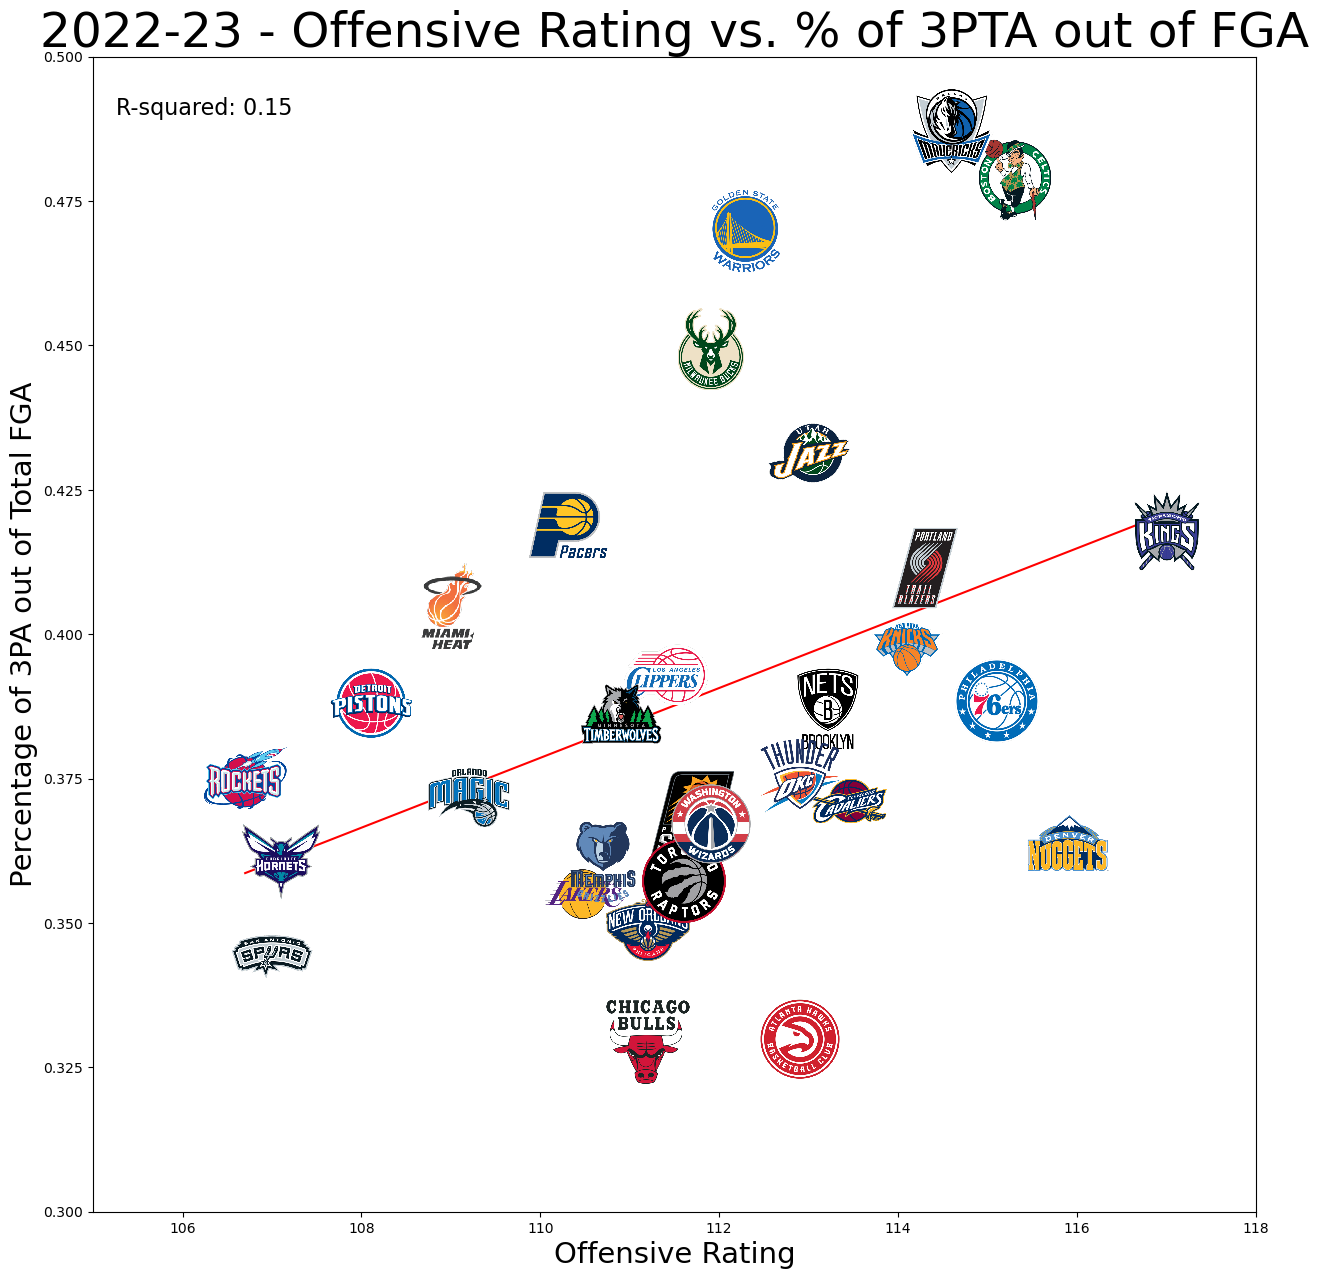

In [61]:
x = data_df['E_OFF_RATING'].values.reshape(-1, 1)
y = data_df['FG3A / FGA'].values.reshape(-1, 1)
paths = data_df['logo_path']

reg = LinearRegression().fit(x, y)

# Get the slope and intercept
slope = reg.coef_[0][0]
intercept = reg.intercept_[0]

# Define the x and y values for the regression line
x_line = np.linspace(x.min(), x.max(), 100).reshape(-1, 1)
y_line = slope * x_line + intercept

# Compute R-squared
y_pred = reg.predict(x)
r2 = r2_score(y, y_pred)

# Define the plot 
fig, ax = plt.subplots()

# Load the data into the plot
for x0, y0, path in zip(x, y, paths):
    ab = AnnotationBbox(getImage(path), (x0, y0), frameon = False)
    ax.add_artist(ab)

# Add the regression line to the plot
ax.plot(x_line, y_line, color='red')

# Add R-squared value to the plot
plt.text(105.25, 0.49, f'R-squared: {r2:.2f}', fontsize=16)

# Plot parameters
# plt.rcParams["figure.figsize"] = (15,15)
plt.xlim(105, 118);
plt.ylim(.3, .5);
plt.title("2022-23 - Offensive Rating vs. % of 3PTA out of FGA", fontdict={'fontsize': 35});
plt.xlabel("Offensive Rating", fontdict={'fontsize' : 21});
plt.ylabel("Percentage of 3PA out of Total FGA", fontdict={'fontsize' : 21});

plt.show()


##### Net Offensive Rating and Pace

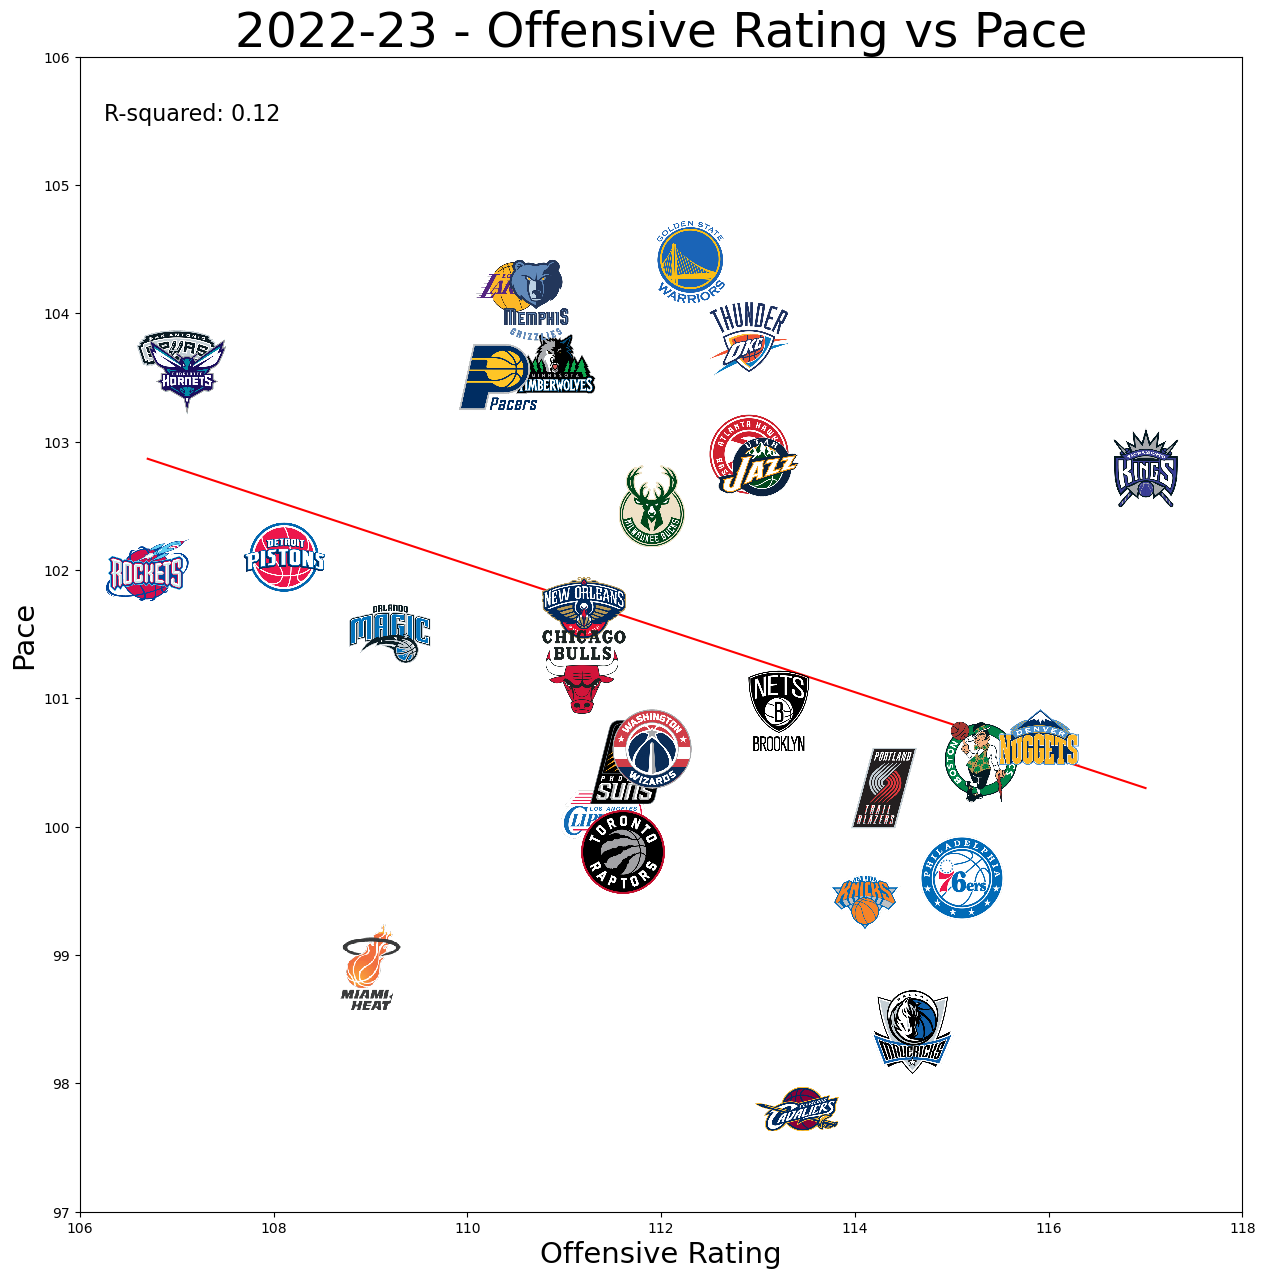

In [60]:
x = data_df['E_OFF_RATING'].values.reshape(-1, 1)
y = data_df['E_PACE'].values.reshape(-1, 1)

reg = LinearRegression().fit(x, y)

# Get the slope and intercept
slope = reg.coef_[0][0]
intercept = reg.intercept_[0]

# Define the x and y values for the regression line
x_line = np.linspace(x.min(), x.max(), 100).reshape(-1, 1)
y_line = slope * x_line + intercept

# Compute R-squared
y_pred = reg.predict(x)
r2 = r2_score(y, y_pred)

# Define the plot 
fig, ax = plt.subplots()

# Load the data into the plot
for x0, y0, path in zip(x, y, paths):
    ab = AnnotationBbox(getImage(path), (x0, y0), frameon = False)
    ax.add_artist(ab)

# Add the regression line to the plot
ax.plot(x_line, y_line, color='red')

# Add R-squared value to the plot
plt.text(106.25, 105.5, f'R-squared: {r2:.2f}', fontsize=16)

# Plot parameters
# plt.rcParams["figure.figsize"] = (15,15)
plt.xlim(106, 118);
plt.ylim(97, 106);
plt.title("2022-23 - Offensive Rating vs Pace", fontdict={'fontsize': 35});
plt.xlabel("Offensive Rating", fontdict={'fontsize' : 21});
plt.ylabel("Pace", fontdict={'fontsize' : 21});

plt.show()

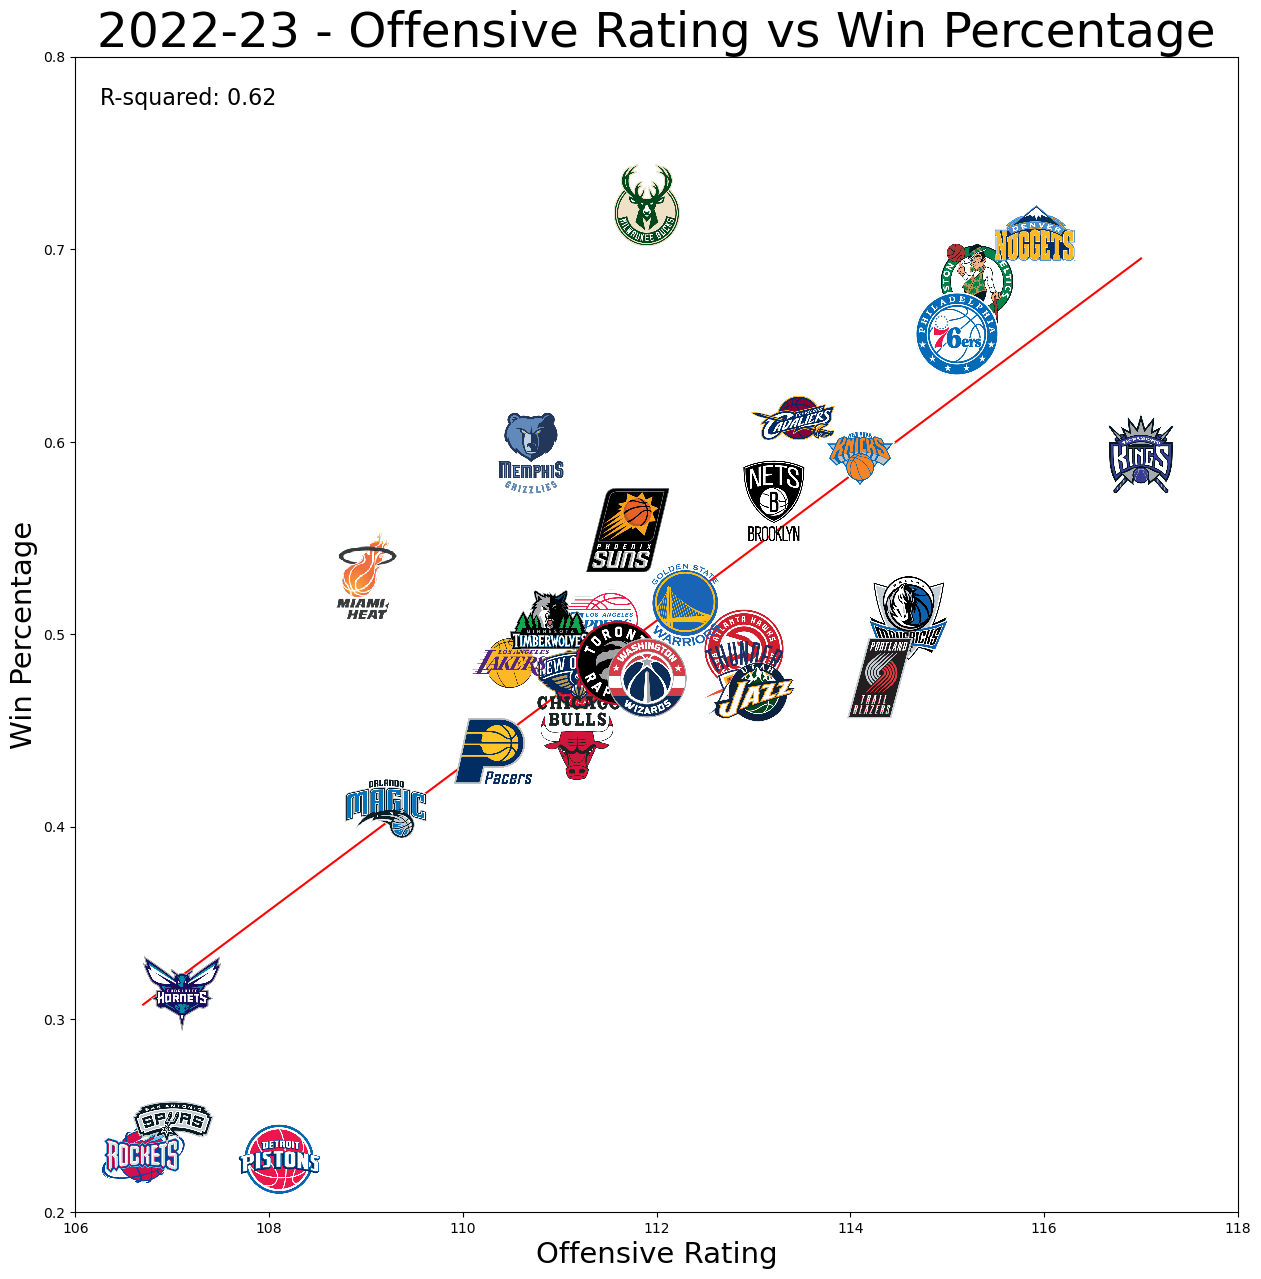

In [62]:
x = data_df['E_OFF_RATING'].values.reshape(-1, 1)
y = data_df['W_PCT_per100'].values.reshape(-1, 1)

reg = LinearRegression().fit(x, y)

# Get the slope and intercept
slope = reg.coef_[0][0]
intercept = reg.intercept_[0]

# Define the x and y values for the regression line
x_line = np.linspace(x.min(), x.max(), 100).reshape(-1, 1)
y_line = slope * x_line + intercept

# Compute R-squared
y_pred = reg.predict(x)
r2 = r2_score(y, y_pred)

# Define the plot 
fig, ax = plt.subplots()

# Load the data into the plot
for x0, y0, path in zip(x, y, paths):
    ab = AnnotationBbox(getImage(path), (x0, y0), frameon = False)
    ax.add_artist(ab)

# Add the regression line to the plot
ax.plot(x_line, y_line, color='red')

# Add R-squared value to the plot
plt.text(106.25, .775, f'R-squared: {r2:.2f}', fontsize=16)

# Plot parameters
plt.xlim(106, 118);
plt.ylim(.2, .8);
plt.title("2022-23 - Offensive Rating vs Win Percentage", fontdict={'fontsize': 35});
plt.xlabel("Offensive Rating", fontdict={'fontsize' : 21});
plt.ylabel("Win Percentage", fontdict={'fontsize' : 21});

plt.show()

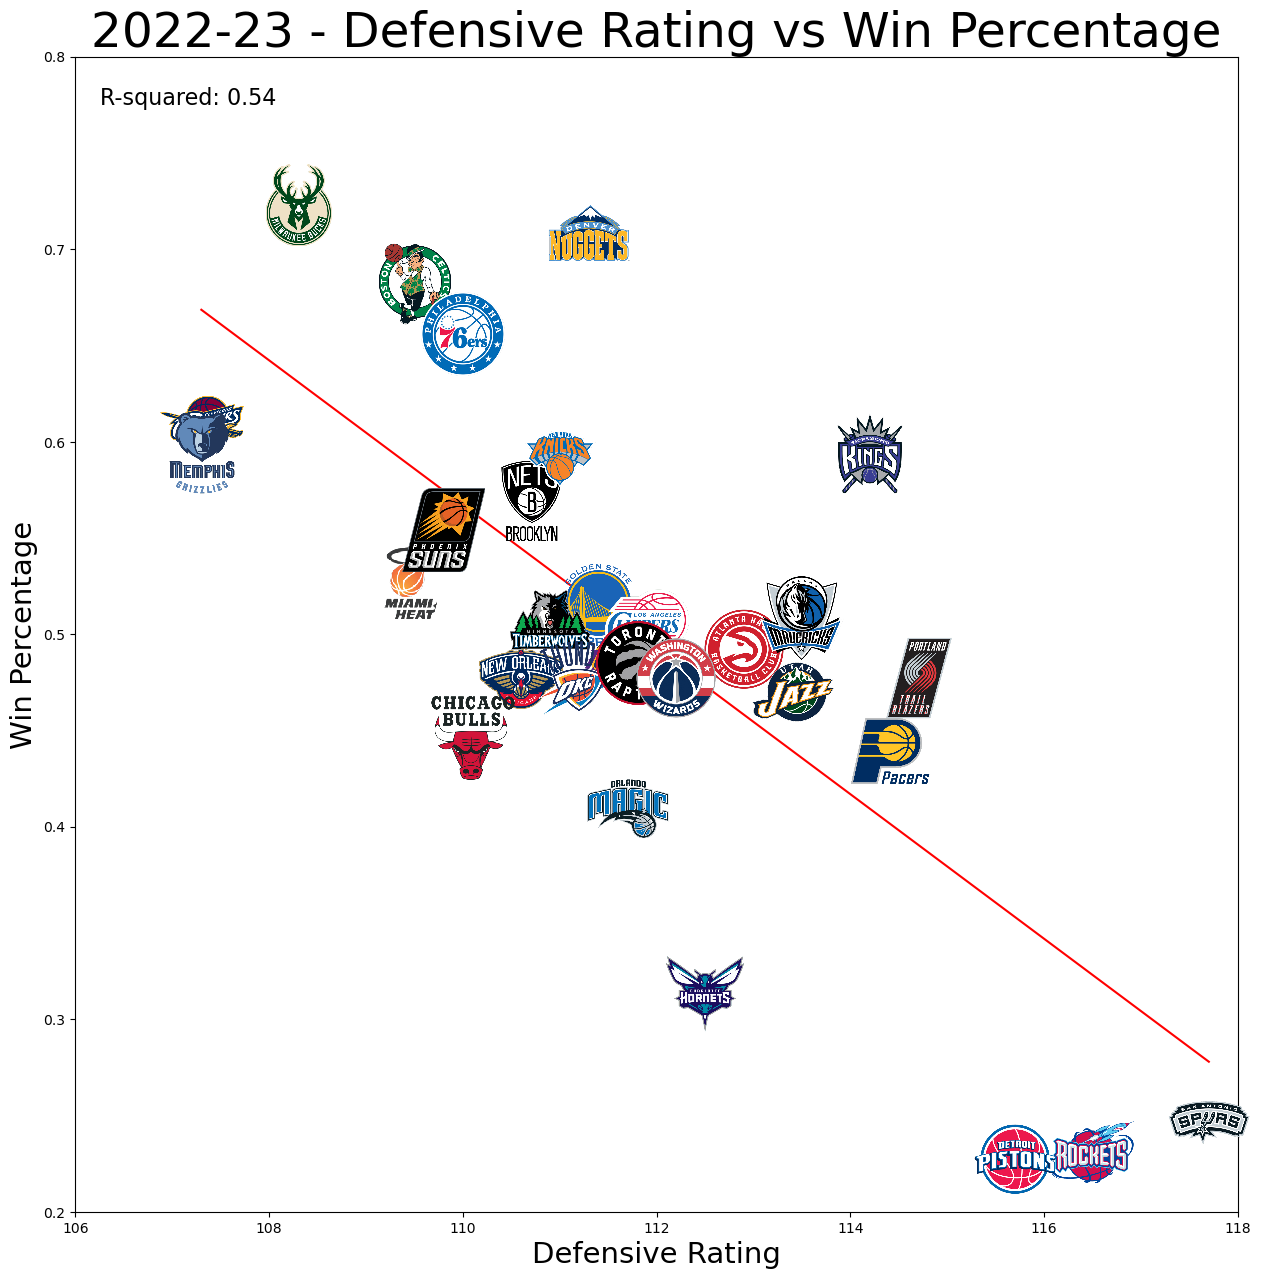

In [63]:
x = data_df['E_DEF_RATING'].values.reshape(-1, 1)
y = data_df['W_PCT_per100'].values.reshape(-1, 1)

reg = LinearRegression().fit(x, y)

# Get the slope and intercept
slope = reg.coef_[0][0]
intercept = reg.intercept_[0]

# Define the x and y values for the regression line
x_line = np.linspace(x.min(), x.max(), 100).reshape(-1, 1)
y_line = slope * x_line + intercept

# Compute R-squared
y_pred = reg.predict(x)
r2 = r2_score(y, y_pred)

# Define the plot 
fig, ax = plt.subplots()

# Load the data into the plot
for x0, y0, path in zip(x, y, paths):
    ab = AnnotationBbox(getImage(path), (x0, y0), frameon = False)
    ax.add_artist(ab)

# Add the regression line to the plot
ax.plot(x_line, y_line, color='red')

# Add R-squared value to the plot
plt.text(106.25, .775, f'R-squared: {r2:.2f}', fontsize=16)

# Plot parameters
plt.xlim(106, 118);
plt.ylim(.2, .8);
plt.title("2022-23 - Defensive Rating vs Win Percentage", fontdict={'fontsize': 35});
plt.xlabel("Defensive Rating", fontdict={'fontsize' : 21});
plt.ylabel("Win Percentage", fontdict={'fontsize' : 21});

plt.show()

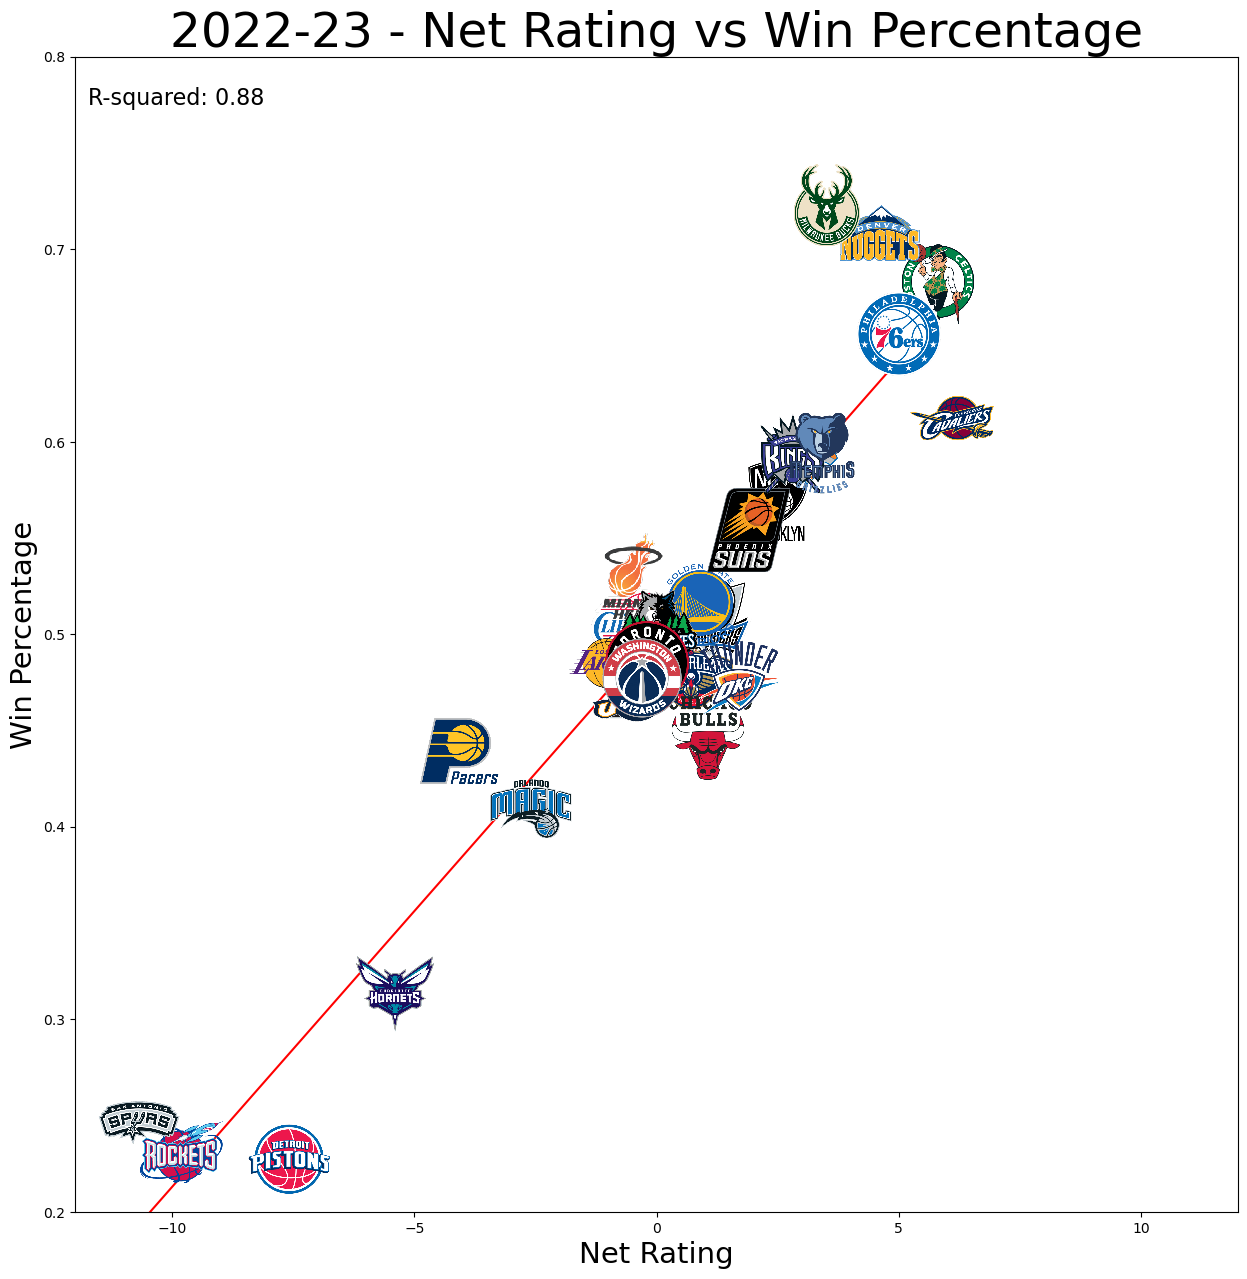

In [66]:
x = data_df['E_NET_RATING'].values.reshape(-1, 1)
y = data_df['W_PCT_per100'].values.reshape(-1, 1)

reg = LinearRegression().fit(x, y)

# Get the slope and intercept
slope = reg.coef_[0][0]
intercept = reg.intercept_[0]

# Define the x and y values for the regression line
x_line = np.linspace(x.min(), x.max(), 100).reshape(-1, 1)
y_line = slope * x_line + intercept

# Compute R-squared
y_pred = reg.predict(x)
r2 = r2_score(y, y_pred)

# Define the plot 
fig, ax = plt.subplots()

# Load the data into the plot
for x0, y0, path in zip(x, y, paths):
    ab = AnnotationBbox(getImage(path), (x0, y0), frameon = False)
    ax.add_artist(ab)

# Add the regression line to the plot
ax.plot(x_line, y_line, color='red')

# Add R-squared value to the plot
plt.text(-011.75, .775, f'R-squared: {r2:.2f}', fontsize=16)

# Plot parameters
plt.xlim(-12, 12);
plt.ylim(.2, .8);
plt.title("2022-23 - Net Rating vs Win Percentage", fontdict={'fontsize': 35});
plt.xlabel("Net Rating", fontdict={'fontsize' : 21});
plt.ylabel("Win Percentage", fontdict={'fontsize' : 21});

plt.show()